In [1]:
!pip install transformers accelerate evaluate datasets peft -q

In [2]:
import transformers
import accelerate
import peft

print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")
"Transformers version: 4.27.4"
"Accelerate version: 0.18.0"
"PEFT version: 0.2.0"

Transformers version: 4.35.2
Accelerate version: 0.25.0
PEFT version: 0.6.2


'PEFT version: 0.2.0'

In [44]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
model_checkpoint = "google/vit-base-patch16-224-in21k"

In [5]:
from datasets import load_dataset

dataset = load_dataset("food101", split="train[:5000]")

In [6]:
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]
"baklava"

'baklava'

In [7]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

In [8]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [9]:
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits["train"]
val_ds = splits["test"]

In [10]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [11]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [25]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
print_trainable_parameters(model)
"trainable params: 85876325 || all params: 85876325 || trainable%: 100.00"

trainable params: 85876325 || all params: 85876325 || trainable%: 100.00


'trainable params: 85876325 || all params: 85876325 || trainable%: 100.00'

In [14]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)
"trainable params: 667493 || all params: 86466149 || trainable%: 0.77"

trainable params: 667493 || all params: 86543818 || trainable%: 0.77


'trainable params: 667493 || all params: 86466149 || trainable%: 0.77'

In [39]:
from transformers import TrainingArguments, Trainer


model_name = model_checkpoint.split("/")[-1]
batch_size = 128

args = TrainingArguments(
    output_dir = "my-awesome-model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    label_names=["labels"],
)

In [40]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [41]:
import torch


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [47]:
repo_name = f"mkahoush01/Image-classification"
lora_model.push_to_hub(repo_name)

adapter_model.safetensors:   0%|          | 0.00/2.68M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mkahoush01/Image-classification/commit/5ebcc091bc91be4fc52bdba7072018f02535d51d', commit_message='Upload model', commit_description='', oid='5ebcc091bc91be4fc52bdba7072018f02535d51d', pr_url=None, pr_revision=None, pr_num=None)

In [46]:
trainer = Trainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.552246,0.882000
2,2.199300,0.174885,0.958000
3,0.347600,0.136652,0.954000
4,0.201800,0.132453,0.962000
5,0.169400,0.126244,0.960000


In [48]:
trainer.evaluate(val_ds)
{
    "eval_loss": 0.14475855231285095,
    "eval_accuracy": 0.96,
    "eval_runtime": 3.5725,
    "eval_samples_per_second": 139.958,
    "eval_steps_per_second": 1.12,
    "epoch": 5.0,
}

{'eval_loss': 0.14475855231285095,
 'eval_accuracy': 0.96,
 'eval_runtime': 3.5725,
 'eval_samples_per_second': 139.958,
 'eval_steps_per_second': 1.12,
 'epoch': 5.0}

In [49]:
from peft import PeftConfig, PeftModel


config = PeftConfig.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Load the LoRA model
inference_model = PeftModel.from_pretrained(model, repo_name)

adapter_config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/2.68M [00:00<?, ?B/s]

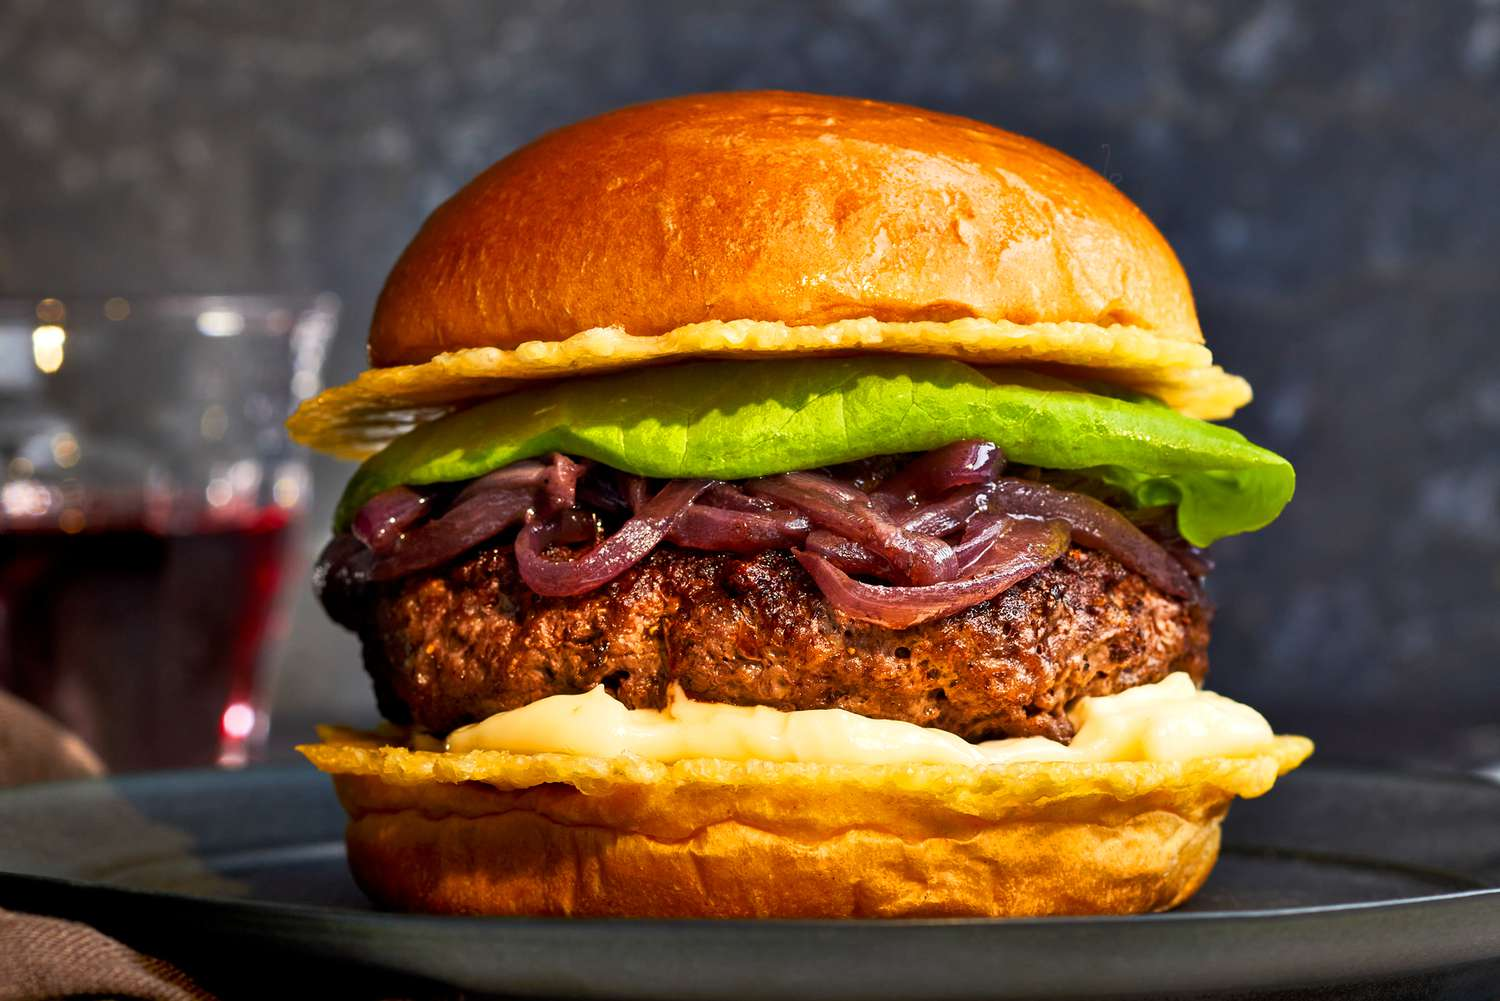

In [59]:
from PIL import Image
import requests

url = "https://www.foodandwine.com/thmb/DI29Houjc_ccAtFKly0BbVsusHc=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/crispy-comte-cheesburgers-FT-RECIPE0921-6166c6552b7148e8a8561f7765ddf20b.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [61]:
image_processor = AutoImageProcessor.from_pretrained(repo_name)

In [62]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt")

In [ ]:
with torch.no_grad():
    outputs = inference_model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", inference_model.config.id2label[predicted_class_idx])

Predicted class: bruschetta
